### Logistic Regression to recognize cats with a Neural Network mindset
### This is the assignment 1 of [Neural Networks and Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning)

## 1 - Packages ##

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
from public_tests import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


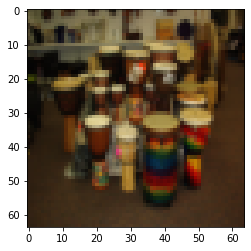

In [5]:
# Example of a picture
index = 5
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

### Exercise 1
Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)

In [6]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


### Exercise 2
Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).


In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Check that the first 10 pixels of the second image are in the correct place
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


Standardize our dataset:

In [8]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

### Exercise 3 - sigmoid
$sigmoid(z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$

In [10]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+np.exp(-z))
    return s

In [11]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid_test(sigmoid)

sigmoid([0, 2]) = [0.5        0.88079708]
All tests passed!


In [12]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


### 4.2 - Initializing parameters with zeros

In [13]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """

    w = np.zeros((dim,1))
    b = 0.

    return w, b

In [14]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))

initialize_with_zeros_test_1(initialize_with_zeros)
initialize_with_zeros_test_2(initialize_with_zeros)


w = [[0.]
 [0.]]
b = 0.0
First test passed!
Second test passed!


<a name='4-3'></a>
### 4.3 - Forward and Backward propagation
### Exercise 5 - propagate
Implement a function `propagate()` that computes the cost function and its gradient.
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [16]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]

    A = sigmoid (np.dot(w.T,X)+b)
    cost = -np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))/m
    
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m 

    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost



In [17]:
w =  np.array([[1.], [2]])
b = 1.5
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

propagate_test(propagate)

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.12500404500439652
cost = 0.15900537707692405
All tests passed!


### 4.4 - Optimization
### Exercise 6 - optimize
For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [18]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):   
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [19]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

optimize_test(optimize)

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]
All tests passed!


### Exercise 7 - predict
1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5)

In [20]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    A = sigmoid (np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        if A[0, i] > 0.5:
             Y_prediction[0,i] = 1 
        else:
             Y_prediction[0,i] = 0
        
    
    return Y_prediction

In [21]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))

predict_test(predict)

predictions = [[1. 1. 0.]]
All tests passed!


## 5 - Merge all functions into a model ##
### Exercise 8 - model


In [24]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w,b =  initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize ( w, b,X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = params["w"]
    b = params["b"]

    Y_prediction_test = predict (w, b,X_test)
    Y_prediction_train = predict (w, b,X_train)
    
    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [25]:
from public_tests import *

model_test(model)

All tests passed!


In [26]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=3000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Cost after iteration 2000: 0.135608
Cost after iteration 2100: 0.130708
Cost after iteration 2200: 0.126137
Cost after iteration 2300: 0.121861
Cost after iteration 2400: 0.117855
Cost after iteration 2500: 0.114093
Cost after iteration 2600: 0.110554
Cost after iteration 2700: 0.107219
Cost

y = 1, you predicted that it is a "non-cat" picture.


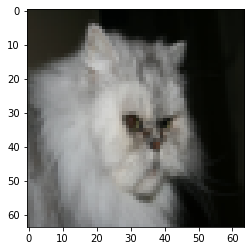

In [34]:
# Example of a picture that was wrongly classified.
index = 10
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

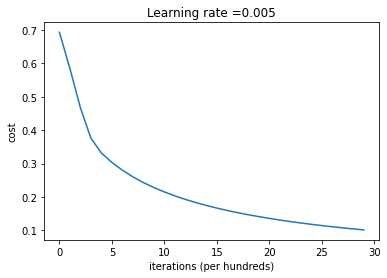

In [35]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

## 6 - Further analysis to examine possible choices for the learning rate $\alpha$. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



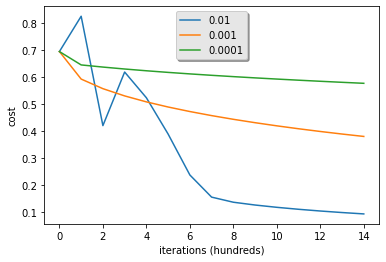

In [36]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## 7 - Test with any image 

y = 0.0, your algorithm predicts a "non-cat" picture.


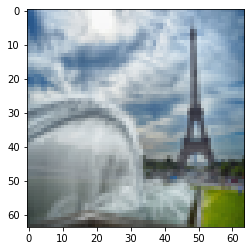

In [38]:
# change this to the name of your image file
my_image = "my_image.jpg"   

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")